In [ ]:
# Install required packages
!pip install librosa tensorflow-hub panns-inference kagglehub tqdm

In [ ]:
# Import libraries
import os
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
import tensorflow_hub as hub
import torch
import torchaudio
from tqdm import tqdm
import warnings
import kagglehub
warnings.filterwarnings('ignore')

In [ ]:
# Check GPU availability
print("GPU Available:", tf.config.experimental.list_physical_devices('GPU'))
print("CUDA Available:", torch.cuda.is_available())


GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
CUDA Available: True


In [ ]:
# ==========================================
# STEP 2: Download Dataset
# ==========================================

print("Downloading dataset...")
dataset_path = kagglehub.dataset_download("murtadhanajim/gender-recognition-by-voiceoriginal")
print(f"Dataset downloaded to: {dataset_path}")

100%|██████████| 1.31G/1.31G [00:20<00:00, 69.4MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/murtadhanajim/gender-recognition-by-voiceoriginal/versions/1


In [ ]:
# ==========================================
# STEP 3: Model Loading Functions
# ==========================================

import tensorflow as tf

class AudioFeatureExtractor:
    def __init__(self):
        """Initialize the three pre-trained models"""
        print("Loading pre-trained models")

        """
        In our baseline paper, the authors extracted the signal features using the following PTMs;
        VGGish, YAMNet, and PANNs with 128, 1024 and 2048 dimensions respectively.
        We replicated the same feature extraction pipeline as mentioned in the paper for our project.
        """

        # 1. VGGish Model (128-dimensional features)
        print("Loading VGGish...")
        self.vggish_model = hub.load('https://tfhub.dev/google/vggish/1')

        # 2. YAMNet Model (1024-dimensional features)
        print("Loading YAMNet...")
        self.yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

        # 3. PANNs Model (2048-dimensional features)
        print("Setting up PANNs...")
        self.setup_panns()

        print("All models loaded successfully!")

    def setup_panns(self):
        """Setup PANNs model"""
        try:
            from panns_inference import AudioTagging
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
            self.panns_model = AudioTagging(checkpoint_path=None, device=device)
            print(f"PANNs loaded on {device}")
        except Exception as e:
            print(f"Error loading PANNs: {e}")
            print("Installing panns_inference...")
            !pip install panns_inference
            from panns_inference import AudioTagging
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
            self.panns_model = AudioTagging(checkpoint_path=None, device=device)

    def load_audio(self, file_path, target_sr=16000):
        """Load and preprocess audio file with error handling"""
        try:
            audio, sr = librosa.load(file_path, sr=target_sr, mono=True, duration=4.0)
            return audio, sr
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            return None, None

    def extract_vggish_features(self, audio, sr=16000):
        """VGGish feature extraction with NaN handling"""
        try:
            # Handle empty/short audio (minimum 0.96s required by VGGish)
            if len(audio) < 960:  # 0.96s * 16000 Hz
                print(f"Audio too short ({len(audio)/sr:.2f}s), returning zeros")
                return np.zeros(128)

            # Convert to TensorFlow tensor
            audio_tensor = tf.convert_to_tensor(audio, dtype=tf.float32)

            # Extract embeddings, returns features for each 0.96s segment
            embeddings = self.vggish_model(audio_tensor)

            # Check for NaN immediately
            if tf.reduce_any(tf.math.is_nan(embeddings)):
                print("NaN detected in embeddings, using zeros")
                return np.zeros(128)

            # Average across time dimension
            if len(embeddings.shape) > 1:
                features = tf.reduce_mean(embeddings, axis=0)
            else:
                features = embeddings

            # Convert to numpy and final NaN check
            features_np = features.numpy()
            if np.isnan(features_np).any():
                print("NaN in final features, using zeros")
                return np.zeros(128)

            return features_np

        except Exception as e:
            print(f"VGGish extraction error: {e}")
            return np.zeros(128)

    def extract_yamnet_features(self, audio, sr=16000):
        """YAMNet feature extraction with error handling"""
        try:
            if len(audio) == 0:
                return np.zeros(1024)

            audio_tensor = tf.convert_to_tensor(audio, dtype=tf.float32)

            # Get YAMNet outputs: scores, embeddings, spectrogram
            scores, embeddings, spectrogram = self.yamnet_model(audio_tensor)

            # Check for NaN
            if tf.reduce_any(tf.math.is_nan(embeddings)):
                print("NaN detected in YAMNet embeddings, using zeros")
                return np.zeros(1024)

            # Average embeddings across time
            if len(embeddings.shape) > 1:
                features = tf.reduce_mean(embeddings, axis=0)
            else:
                features = embeddings

            # Final NaN check
            features_np = features.numpy()
            if np.isnan(features_np).any():
                print("NaN in final YAMNet features, using zeros")
                return np.zeros(1024)

            return features_np

        except Exception as e:
            print(f"YAMNet extraction error: {e}")
            return np.zeros(1024)

    def extract_panns_features(self, audio, sr=16000):
      """PANNs feature extraction with error handling"""
      try:
          if len(audio) == 0:
              return np.zeros(2048)

          if sr != 32000:
              audio_32k = librosa.resample(audio, orig_sr=sr, target_sr=32000)
          else:
              audio_32k = audio

          # Check minimum length
          if len(audio_32k) < 32000:
              return np.zeros(2048)

          # Get inference
          (clipwise_output, embedding) = self.panns_model.inference(audio_32k[None, :])

          # Convert to numpy
          if isinstance(embedding, torch.Tensor):
              embedding = embedding.cpu().numpy()

          # Check for NaN using NumPy
          if np.isnan(embedding).any():
              return np.zeros(2048)

          # Handle embedding shape
          embedding = embedding.squeeze()
          if embedding.ndim == 0:  # Scalar case
              return np.zeros(2048)
          elif embedding.size > 2048:
              return embedding[:2048]
          elif embedding.size < 2048:
              padded = np.zeros(2048)
              padded[:embedding.size] = embedding
              return padded
          return embedding

      except Exception as e:
          print(f"PANNs extraction error: {e}")
          return np.zeros(2048)

    def extract_all_features(self, file_path):
        """Extract features from all three models for a single audio file"""
        # Load audio at 16kHz
        audio, sr = self.load_audio(file_path, target_sr=16000)

        if audio is None:
            return {
                'vggish': np.zeros(128),
                'yamnet': np.zeros(1024),
                'panns': np.zeros(2048)
            }

        # Extract features from each model
        features = {
            'vggish': self.extract_vggish_features(audio, sr),
            'yamnet': self.extract_yamnet_features(audio, sr),
            'panns': self.extract_panns_features(audio, sr)
        }

        return features




In [ ]:

# ==========================================
# STEP 4: Dataset Processing Function
# ==========================================

def process_gender_dataset(dataset_path, output_dir='./audio_features'):
    """Process the gender recognition dataset and extract features with fixed labeling"""
    os.makedirs(output_dir, exist_ok=True)

    # Initialize extractor
    print("Initializing feature extractor...")
    extractor = AudioFeatureExtractor()

    # Find all audio files
    audio_extensions = ['.wav', '.mp3', '.flac', '.m4a', '.ogg']
    audio_files = []

    print("Scanning for audio files...")
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if any(file.lower().endswith(ext) for ext in audio_extensions):
                audio_files.append(os.path.join(root, file))

    print(f"Found {len(audio_files)} audio files")

    if len(audio_files) == 0:
        print("No audio files found! Please check the dataset path.")
        return None, None

    # Initialize feature storage
    features_dict = {
        'vggish': [],
        'yamnet': [],
        'panns': []
    }

    file_metadata = []
    failed_files = 0

    # Process each file

    print("Extracting features...")
    male_count = 0
    female_count = 0
    unknown_count = 0

    for i, file_path in enumerate(tqdm(audio_files, desc="Processing audio files")):
        try:
            # Extract features
            features = extractor.extract_all_features(file_path)

            # Store features
            features_dict['vggish'].append(features['vggish'])
            features_dict['yamnet'].append(features['yamnet'])
            features_dict['panns'].append(features['panns'])

            # Extract gender from directory structure
            gender = 'unknown'
            path_parts = file_path.lower().split(os.sep)

            # Check all directory levels for gender indicators
            if 'female' in path_parts:
                gender = 'female'
                female_count += 1
            elif 'male' in path_parts:
                gender = 'male'
                male_count += 1
            else:
                # Try to detect from filename
                if 'female' in os.path.basename(file_path).lower():
                    gender = 'female'
                    female_count += 1
                elif 'male' in os.path.basename(file_path).lower():
                    gender = 'male'
                    male_count += 1
                else:
                    gender = 'unknown'
                    unknown_count += 1

            file_metadata.append({
                'index': i,
                'filename': os.path.basename(file_path),
                'file_path': file_path,
                'gender': gender
            })

        except Exception as e:
            failed_files += 1
            print(f"Error processing {file_path}: {e}")
            features_dict['vggish'].append(np.zeros(128))
            features_dict['yamnet'].append(np.zeros(1024))
            features_dict['panns'].append(np.zeros(2048))
            file_metadata.append({
                'index': i,
                'filename': os.path.basename(file_path),
                'file_path': file_path,
                'gender': 'unknown'
            })

    print(f"Failed to process {failed_files}/{len(audio_files)} files")

    print(f"Gender detection results:")
    print(f" - Male: {male_count}")
    print(f" - Female: {female_count}")
    print(f" - Unknown: {unknown_count}")


    # Convert to numpy arrays
    for model_name in features_dict:
        features_dict[model_name] = np.array(features_dict[model_name])
        print(f"{model_name.upper()} features shape: {features_dict[model_name].shape}")

    # Save features
    print("Saving extracted features...")
    for model_name, features_array in features_dict.items():
        np.save(os.path.join(output_dir, f'{model_name}_features.npy'), features_array)

    # Save metadata
    metadata_df = pd.DataFrame(file_metadata)
    metadata_df.to_csv(os.path.join(output_dir, 'file_metadata.csv'), index=False)

    print(f"Features saved to: {output_dir}")

    # Clean NaN values
    clean_features(output_dir)

    return features_dict, metadata_df


In [ ]:
# ==========================================
# Feature Cleaning Function
# ==========================================

def clean_features(features_dir='./audio_features'):
    """Clean NaN values from features and update metadata"""
    print("Cleaning NaN values from features...")
    features = {
        'vggish': np.load(os.path.join(features_dir, 'vggish_features.npy')),
        'yamnet': np.load(os.path.join(features_dir, 'yamnet_features.npy')),
        'panns': np.load(os.path.join(features_dir, 'panns_features.npy'))
    }
    metadata = pd.read_csv(os.path.join(features_dir, 'file_metadata.csv'))

    # Identify NaN rows in VGGish
    nan_mask = np.isnan(features['vggish']).any(axis=1)
    nan_count = nan_mask.sum()
    print(f"Found {nan_count} files with NaN values in VGGish features")

    # Remove NaN rows from all features and metadata
    if nan_count > 0:
        for model in features:
            features[model] = features[model][~nan_mask]
        metadata = metadata[~nan_mask]

        # Save cleaned versions
        np.save(os.path.join(features_dir, 'vggish_features.npy'), features['vggish'])
        np.save(os.path.join(features_dir, 'yamnet_features.npy'), features['yamnet'])
        np.save(os.path.join(features_dir, 'panns_features.npy'), features['panns'])
        metadata.to_csv(os.path.join(features_dir, 'file_metadata.csv'), index=False)
        print(f"Saved cleaned features without {nan_count} NaN entries")

    # Verify all features
    for model, array in features.items():
        nan_count = np.isnan(array).sum()
        print(f"{model.upper()} NaN count after cleaning: {nan_count}")

    return features, metadata

In [ ]:
# ==========================================
# STEP 5: Execute Feature Extraction
# ==========================================

print("Starting feature extraction process...")
features, metadata = process_gender_dataset(dataset_path)

if features is not None:
    print("\n" + "="*50)
    print("FEATURE EXTRACTION COMPLETED SUCCESSFULLY!")
    print("="*50)

    # Display final results
    print("Feature dimensions match paper specifications:")
    print(f"✓ VGGish: {features['vggish'].shape[1]} dimensions (expected: 128)")
    print(f"✓ YAMNet: {features['yamnet'].shape[1]} dimensions (expected: 1024)")
    print(f"✓ PANNs: {features['panns'].shape[1]} dimensions (expected: 2048)")

    print("\nFeature statistics after cleaning:")
    for model in ['vggish', 'yamnet', 'panns']:
        array = features[model]
        print(f"\n{model.upper()} Features:")
        print(f"  Shape: {array.shape}")
        print(f"  Mean: {np.mean(array):.4f}")
        print(f"  Std: {np.std(array):.4f}")
        print(f"  Min: {np.min(array):.4f}")
        print(f"  Max: {np.max(array):.4f}")
        print(f"  NaN count: {np.isnan(array).sum()}")

    # Gender distribution
    print("\nGender Distribution:")
    print(metadata['gender'].value_counts())

    print(f"\nFeatures saved in './audio_features/' directory")
    print("Files created:")
    print("- vggish_features.npy")
    print("- yamnet_features.npy")
    print("- panns_features.npy")
    print("- file_metadata.csv")

else:
    print("Feature extraction failed. Please check the dataset path and file formats.")

Starting feature extraction process...
Initializing feature extractor...
Loading pre-trained models...
Loading VGGish...
Loading YAMNet...
Setting up PANNs...
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
GPU number: 1
PANNs loaded on cuda
All models loaded successfully!
Scanning for audio files...
Found 16148 audio files
Extracting features...


Processing audio files:  25%|██▍       | 3957/16148 [01:35<04:36, 44.10it/s]

NaN in final features, using zeros


Processing audio files:  41%|████      | 6626/16148 [02:38<03:54, 40.66it/s]

NaN in final features, using zeros


Processing audio files:  48%|████▊     | 7787/16148 [03:06<03:02, 45.93it/s]

NaN in final features, using zeros


Processing audio files:  94%|█████████▍| 15228/16148 [06:01<00:20, 45.48it/s]

NaN in final features, using zeros


Processing audio files: 100%|██████████| 16148/16148 [06:22<00:00, 42.16it/s]


Failed to process 0/16148 files
Gender detection results:
 - Male: 10380
 - Female: 5768
 - Unknown: 0
VGGISH features shape: (16148, 128)
YAMNET features shape: (16148, 1024)
PANNS features shape: (16148, 2048)
Saving extracted features...
Features saved to: ./audio_features
Cleaning NaN values from features...
Found 0 files with NaN values in VGGish features
VGGISH NaN count after cleaning: 0
YAMNET NaN count after cleaning: 0
PANNS NaN count after cleaning: 0

FEATURE EXTRACTION COMPLETED SUCCESSFULLY!
Feature dimensions match paper specifications:
✓ VGGish: 128 dimensions (expected: 128)
✓ YAMNet: 1024 dimensions (expected: 1024)
✓ PANNs: 2048 dimensions (expected: 2048)

Feature statistics after cleaning:

VGGISH Features:
  Shape: (16148, 128)
  Mean: -0.1273
  Std: 0.4228
  Min: -2.4929
  Max: 3.1819
  NaN count: 0

YAMNET Features:
  Shape: (16148, 1024)
  Mean: 0.1046
  Std: 0.2167
  Min: 0.0000
  Max: 3.7249
  NaN count: 0

PANNS Features:
  Shape: (16148, 2048)
  Mean: 0.094

In [ ]:
# ==========================================
# STEP 6: Feature Loading Function for Later Use
# ==========================================

def load_extracted_features(features_dir='./audio_features'):
    """Load previously extracted features"""
    try:
        features = {}
        features['vggish'] = np.load(os.path.join(features_dir, 'vggish_features.npy'))
        features['yamnet'] = np.load(os.path.join(features_dir, 'yamnet_features.npy'))
        features['panns'] = np.load(os.path.join(features_dir, 'panns_features.npy'))

        metadata = pd.read_csv(os.path.join(features_dir, 'file_metadata.csv'))

        print("Features loaded successfully!")
        for model_name, feature_array in features.items():
            print(f"{model_name}: {feature_array.shape}")

        return features, metadata

    except Exception as e:
        print(f"Error loading features: {e}")
        return None, None


features, metadata = load_extracted_features()



Features loaded successfully!
vggish: (16148, 128)
yamnet: (16148, 1024)
panns: (16148, 2048)


In [ ]:
#Inspecting the VGGish features array
print("VGGish Features Shape:", features['vggish'].shape)
print("First 5 VGGish Features:")
print(features['vggish'][:5])


VGGish Features Shape: (16148, 128)
First 5 VGGish Features:
[[ 7.74005949e-01 -1.89687461e-01 -1.05335176e-01 -7.11832404e-01
   2.05323473e-02 -2.55594671e-01 -5.94246507e-01  3.04802746e-01
  -1.16311431e+00 -3.92439574e-01 -8.47335577e-01 -1.54059812e-01
  -1.05702627e+00 -4.05967742e-01 -2.88982689e-01  3.70586574e-01
  -1.34427613e-02  1.23277567e-01 -2.57122338e-01 -7.83988982e-02
   4.04420018e-01  1.16642140e-01 -4.75556552e-01  9.38721955e-01
   1.79019243e-01 -4.93628144e-01 -1.09166726e-01  5.14383495e-01
  -5.22107363e-01 -5.03930688e-01 -5.81690907e-01 -3.63346562e-02
  -1.48442075e-01  1.80772036e-01  5.11877835e-01 -2.69186765e-01
  -7.78719008e-01 -2.26162672e-01 -1.20677757e+00 -5.37893832e-01
   3.67419720e-01 -7.51280904e-01 -1.33599713e-01 -5.03312230e-01
   1.23834714e-01 -1.24452434e-01  1.79321438e-01  1.88618049e-01
  -2.53521651e-02  4.40409243e-01  1.95184499e-01 -6.71187997e-01
   5.72765395e-02 -1.07516718e+00  3.48790288e-01 -8.16617846e-01
  -1.10780299e-

In [ ]:
# Check for NaN values in VGGish features
nan_in_vggish = np.isnan(features['vggish']).any()
print(f"Are there any NaN values in VGGish features? {nan_in_vggish}")

if nan_in_vggish:
    nan_rows_vggish = np.isnan(features['vggish']).any(axis=1)
    num_nan_rows_vggish = np.sum(nan_rows_vggish)
    print(f"Number of rows with NaN values in VGGish features: {num_nan_rows_vggish}")

    nan_row_indices_vggish = np.where(nan_rows_vggish)[0]
    print(f"Indices of rows with NaN values (first 10): {nan_row_indices_vggish[:10]}")

    # To see the metadata for these files
    if metadata is not None:
        print("\nMetadata for first 10 files with NaN in VGGish features:")
        display(metadata.iloc[nan_row_indices_vggish[:10]])

Are there any NaN values in VGGish features? False


In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.7 MB/s eta 0:00:00


## Summary:

### Data Analysis Key Findings

*   The initial attempt to construct a graph for gender classification using k-nearest neighbors failed because the `torch_geometric` library was not installed.
*   After installing the library, the graph construction failed again.
*   Inspection of the `metadata` revealed that all entries in the 'gender' column were labeled as 'unknown'.

### Insights or Next Steps

*   The dataset is not suitable for supervised gender classification due to the lack of valid gender labels.
*   To proceed with a classification task using this dataset, a different target variable with meaningful labels would need to be identified or acquired.


Valid samples: 16148 (Male: 10380, Female: 5768)
Using device: cuda


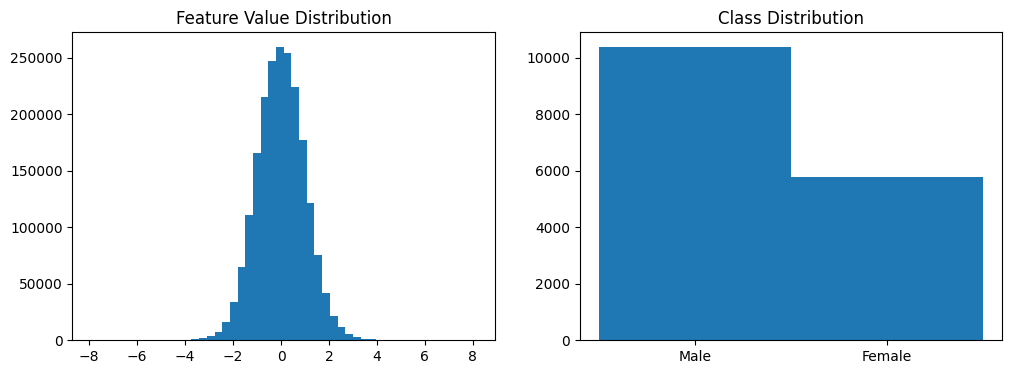

Graph info: 16148 nodes, 161480 edges

Testing simple model first...
Epoch 000: Loss=1.3871, Val Acc=0.7663
Epoch 010: Loss=0.0526, Val Acc=0.9960
Epoch 020: Loss=0.0219, Val Acc=0.9981
Epoch 030: Loss=0.0177, Val Acc=0.9988
Epoch 040: Loss=0.0143, Val Acc=0.9994
Epoch 050: Loss=0.0113, Val Acc=0.9994
Epoch 060: Loss=0.0136, Val Acc=0.9991
Epoch 070: Loss=0.0087, Val Acc=0.9991
Epoch 080: Loss=0.0077, Val Acc=0.9991
Epoch 090: Loss=0.0079, Val Acc=0.9991
Epoch 100: Loss=0.0081, Val Acc=0.9991
Epoch 110: Loss=0.0075, Val Acc=0.9991
Epoch 120: Loss=0.0080, Val Acc=0.9991
Epoch 130: Loss=0.0069, Val Acc=0.9991
Epoch 140: Loss=0.0058, Val Acc=0.9991
Epoch 150: Loss=0.0061, Val Acc=0.9991
Epoch 160: Loss=0.0063, Val Acc=0.9991
Epoch 170: Loss=0.0048, Val Acc=0.9991
Epoch 180: Loss=0.0049, Val Acc=0.9994
Epoch 190: Loss=0.0049, Val Acc=0.9991


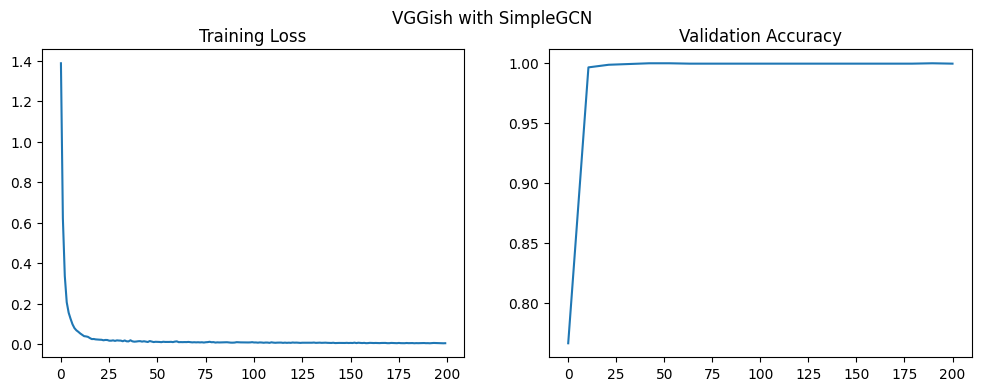

Simple model accuracy: 0.9991

Training GCN with VGGish features
Epoch 000: Loss=0.7190, Val Acc=0.9477
Epoch 010: Loss=0.0146, Val Acc=0.9975
Epoch 020: Loss=0.0092, Val Acc=0.9975
Epoch 030: Loss=0.0064, Val Acc=0.9985
Epoch 040: Loss=0.0058, Val Acc=0.9981
Epoch 050: Loss=0.0051, Val Acc=0.9975
Epoch 060: Loss=0.0044, Val Acc=0.9981
Epoch 070: Loss=0.0039, Val Acc=0.9985
Epoch 080: Loss=0.0035, Val Acc=0.9985
Epoch 090: Loss=0.0040, Val Acc=0.9988
Epoch 100: Loss=0.0033, Val Acc=0.9988
Epoch 110: Loss=0.0033, Val Acc=0.9985
Epoch 120: Loss=0.0032, Val Acc=0.9988
Epoch 130: Loss=0.0030, Val Acc=0.9988
Epoch 140: Loss=0.0026, Val Acc=0.9985
Epoch 150: Loss=0.0028, Val Acc=0.9985
Epoch 160: Loss=0.0024, Val Acc=0.9988
Epoch 170: Loss=0.0024, Val Acc=0.9988
Epoch 180: Loss=0.0024, Val Acc=0.9988
Epoch 190: Loss=0.0024, Val Acc=0.9988


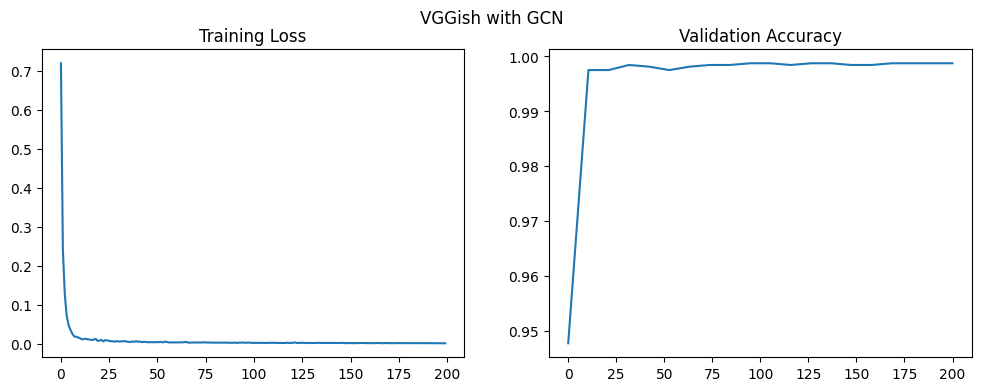

GCN with VGGish: Test Acc = 0.9988

Training GAT with VGGish features
Epoch 000: Loss=0.8812, Val Acc=0.9703
Epoch 010: Loss=0.1028, Val Acc=0.9978
Epoch 020: Loss=0.0797, Val Acc=0.9981
Epoch 030: Loss=0.0698, Val Acc=0.9981
Epoch 040: Loss=0.0642, Val Acc=0.9988
Epoch 050: Loss=0.0562, Val Acc=0.9988
Epoch 060: Loss=0.0590, Val Acc=0.9988
Epoch 070: Loss=0.0581, Val Acc=0.9988
Epoch 080: Loss=0.0591, Val Acc=0.9988
Epoch 090: Loss=0.0603, Val Acc=0.9988
Epoch 100: Loss=0.0586, Val Acc=0.9985
Epoch 110: Loss=0.0569, Val Acc=0.9985
Epoch 120: Loss=0.0559, Val Acc=0.9985
Epoch 130: Loss=0.0570, Val Acc=0.9985
Epoch 140: Loss=0.0567, Val Acc=0.9985
Epoch 150: Loss=0.0530, Val Acc=0.9988
Epoch 160: Loss=0.0547, Val Acc=0.9985
Epoch 170: Loss=0.0567, Val Acc=0.9985
Epoch 180: Loss=0.0551, Val Acc=0.9985
Epoch 190: Loss=0.0563, Val Acc=0.9985


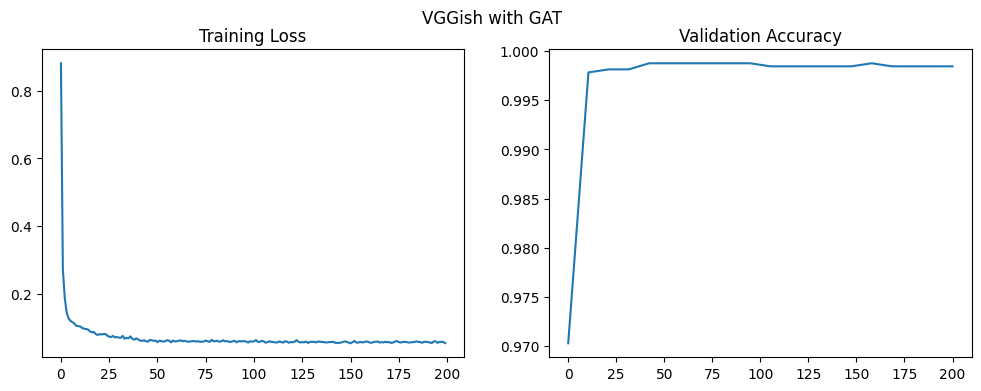

GAT with VGGish: Test Acc = 0.9985

Training GraphSAGE with VGGish features
Epoch 000: Loss=0.7060, Val Acc=0.9700
Epoch 010: Loss=0.0123, Val Acc=0.9972
Epoch 020: Loss=0.0081, Val Acc=0.9985
Epoch 030: Loss=0.0108, Val Acc=0.9978
Epoch 040: Loss=0.0049, Val Acc=0.9972
Epoch 050: Loss=0.0035, Val Acc=0.9985
Epoch 060: Loss=0.0020, Val Acc=0.9981
Epoch 070: Loss=0.0019, Val Acc=0.9985
Epoch 080: Loss=0.0018, Val Acc=0.9985
Epoch 090: Loss=0.0018, Val Acc=0.9985
Epoch 100: Loss=0.0017, Val Acc=0.9985
Epoch 110: Loss=0.0016, Val Acc=0.9985
Epoch 120: Loss=0.0013, Val Acc=0.9985
Epoch 130: Loss=0.0011, Val Acc=0.9985
Epoch 140: Loss=0.0012, Val Acc=0.9985
Epoch 150: Loss=0.0012, Val Acc=0.9985
Epoch 160: Loss=0.0010, Val Acc=0.9985
Epoch 170: Loss=0.0008, Val Acc=0.9985
Epoch 180: Loss=0.0011, Val Acc=0.9985
Epoch 190: Loss=0.0010, Val Acc=0.9985


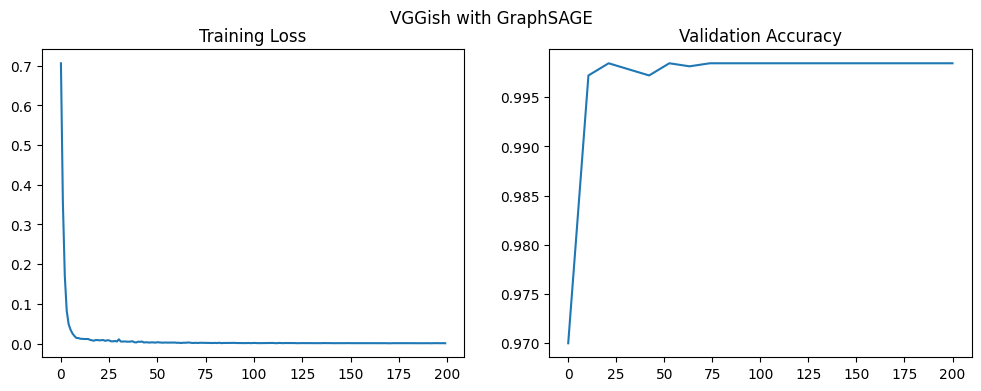

GraphSAGE with VGGish: Test Acc = 0.9985


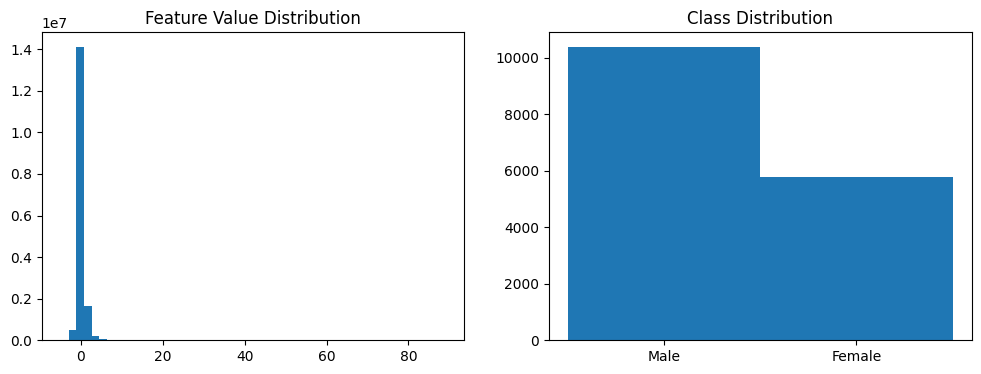

Graph info: 16148 nodes, 161480 edges

Testing simple model first...
Epoch 000: Loss=1.1836, Val Acc=0.9099
Epoch 010: Loss=0.2110, Val Acc=0.9628
Epoch 020: Loss=0.1404, Val Acc=0.9731
Epoch 030: Loss=0.0991, Val Acc=0.9759
Epoch 040: Loss=0.0864, Val Acc=0.9746
Epoch 050: Loss=0.0747, Val Acc=0.9777
Epoch 060: Loss=0.0727, Val Acc=0.9774
Epoch 070: Loss=0.0684, Val Acc=0.9774
Epoch 080: Loss=0.0653, Val Acc=0.9774
Epoch 090: Loss=0.0599, Val Acc=0.9774
Epoch 100: Loss=0.0586, Val Acc=0.9771
Epoch 110: Loss=0.0563, Val Acc=0.9780
Epoch 120: Loss=0.0513, Val Acc=0.9783
Epoch 130: Loss=0.0544, Val Acc=0.9783
Epoch 140: Loss=0.0521, Val Acc=0.9780
Epoch 150: Loss=0.0461, Val Acc=0.9799
Epoch 160: Loss=0.0463, Val Acc=0.9793
Epoch 170: Loss=0.0449, Val Acc=0.9793
Epoch 180: Loss=0.0441, Val Acc=0.9789
Epoch 190: Loss=0.0474, Val Acc=0.9793


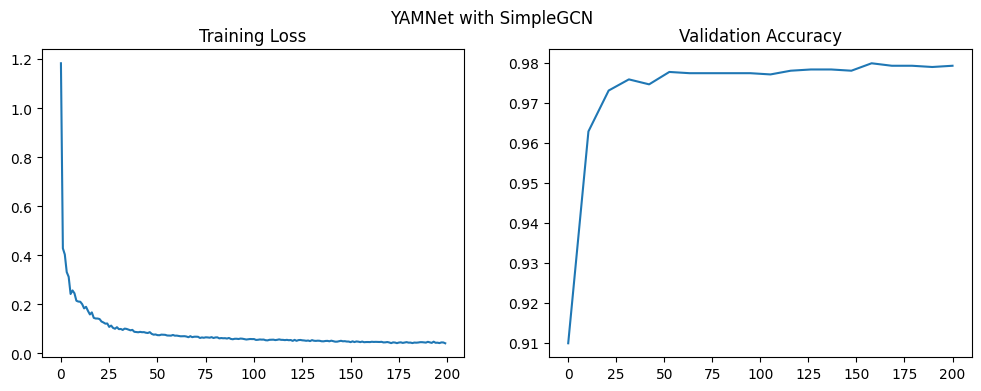

Simple model accuracy: 0.9805

Training GCN with YAMNet features
Epoch 000: Loss=1.2450, Val Acc=0.8220
Epoch 010: Loss=0.2347, Val Acc=0.9672
Epoch 020: Loss=0.1470, Val Acc=0.9715
Epoch 030: Loss=0.1070, Val Acc=0.9718
Epoch 040: Loss=0.0812, Val Acc=0.9718
Epoch 050: Loss=0.0738, Val Acc=0.9746
Epoch 060: Loss=0.0670, Val Acc=0.9771
Epoch 070: Loss=0.0615, Val Acc=0.9780
Epoch 080: Loss=0.0588, Val Acc=0.9777
Epoch 090: Loss=0.0535, Val Acc=0.9783
Epoch 100: Loss=0.0514, Val Acc=0.9780
Epoch 110: Loss=0.0470, Val Acc=0.9771
Epoch 120: Loss=0.0459, Val Acc=0.9762
Epoch 130: Loss=0.0437, Val Acc=0.9780
Epoch 140: Loss=0.0432, Val Acc=0.9774
Epoch 150: Loss=0.0399, Val Acc=0.9774
Epoch 160: Loss=0.0401, Val Acc=0.9771
Epoch 170: Loss=0.0409, Val Acc=0.9777
Epoch 180: Loss=0.0390, Val Acc=0.9789
Epoch 190: Loss=0.0360, Val Acc=0.9762


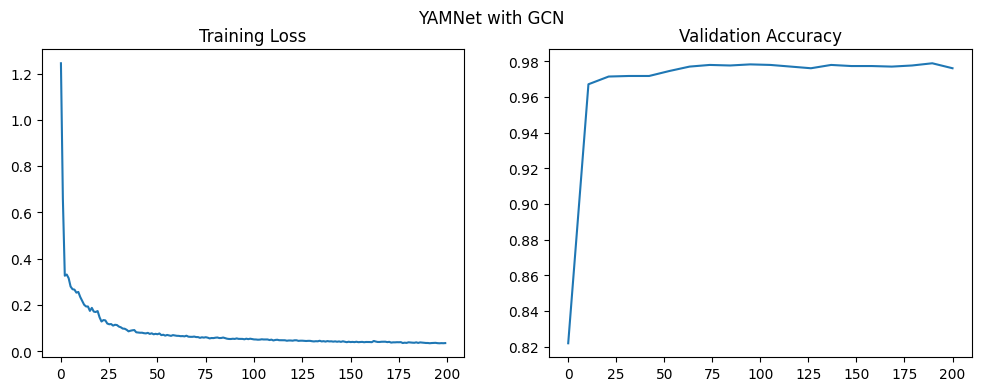

GCN with YAMNet: Test Acc = 0.9780

Training GAT with YAMNet features
Epoch 000: Loss=1.1641, Val Acc=0.7734
Epoch 010: Loss=0.6738, Val Acc=0.9372
Epoch 020: Loss=0.4825, Val Acc=0.9418
Epoch 030: Loss=0.3743, Val Acc=0.9567
Epoch 040: Loss=0.2713, Val Acc=0.9659
Epoch 050: Loss=0.2463, Val Acc=0.9737
Epoch 060: Loss=0.2049, Val Acc=0.9684
Epoch 070: Loss=0.2280, Val Acc=0.9715
Epoch 080: Loss=0.1653, Val Acc=0.9718
Epoch 090: Loss=0.1732, Val Acc=0.9718
Epoch 100: Loss=0.1549, Val Acc=0.9728
Epoch 110: Loss=0.1575, Val Acc=0.9746
Epoch 120: Loss=0.1467, Val Acc=0.9746
Epoch 130: Loss=0.1535, Val Acc=0.9771
Epoch 140: Loss=0.1432, Val Acc=0.9783
Epoch 150: Loss=0.1432, Val Acc=0.9786
Epoch 160: Loss=0.1383, Val Acc=0.9786
Epoch 170: Loss=0.1402, Val Acc=0.9786
Epoch 180: Loss=0.1357, Val Acc=0.9783
Epoch 190: Loss=0.1342, Val Acc=0.9796


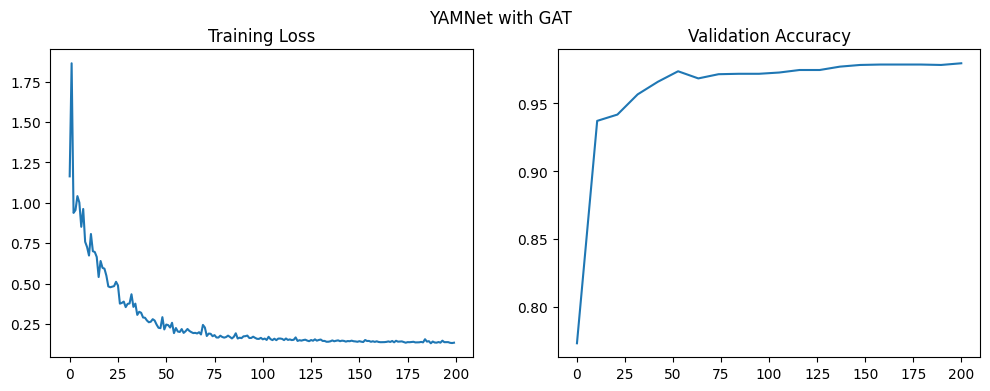

GAT with YAMNet: Test Acc = 0.9796

Training GraphSAGE with YAMNet features
Epoch 000: Loss=0.7231, Val Acc=0.8975
Epoch 010: Loss=0.1011, Val Acc=0.9737
Epoch 020: Loss=0.0544, Val Acc=0.9755
Epoch 030: Loss=0.0385, Val Acc=0.9789
Epoch 040: Loss=0.0271, Val Acc=0.9839
Epoch 050: Loss=0.0218, Val Acc=0.9882
Epoch 060: Loss=0.0164, Val Acc=0.9892
Epoch 070: Loss=0.0118, Val Acc=0.9904
Epoch 080: Loss=0.0101, Val Acc=0.9895
Epoch 090: Loss=0.0081, Val Acc=0.9904
Epoch 100: Loss=0.0062, Val Acc=0.9920
Epoch 110: Loss=0.0080, Val Acc=0.9910
Epoch 120: Loss=0.0081, Val Acc=0.9892
Epoch 130: Loss=0.0061, Val Acc=0.9901
Epoch 140: Loss=0.0059, Val Acc=0.9892
Epoch 150: Loss=0.0126, Val Acc=0.9879
Epoch 160: Loss=0.0078, Val Acc=0.9885
Epoch 170: Loss=0.0085, Val Acc=0.9901
Epoch 180: Loss=0.0083, Val Acc=0.9882
Epoch 190: Loss=0.0075, Val Acc=0.9898


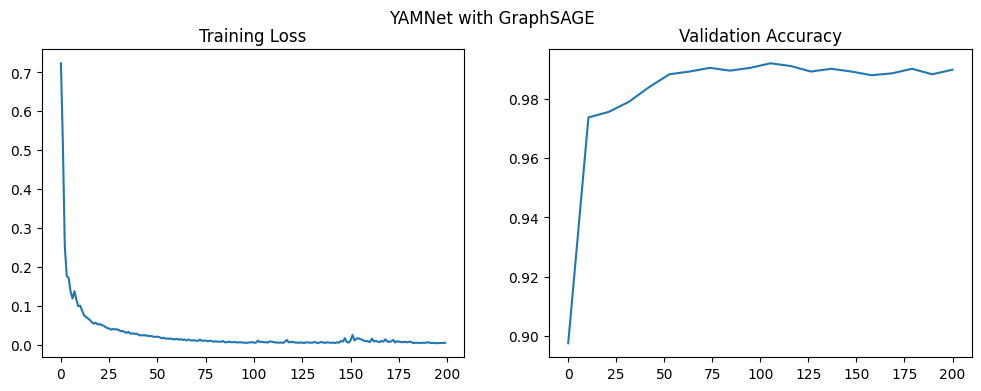

GraphSAGE with YAMNet: Test Acc = 0.9898


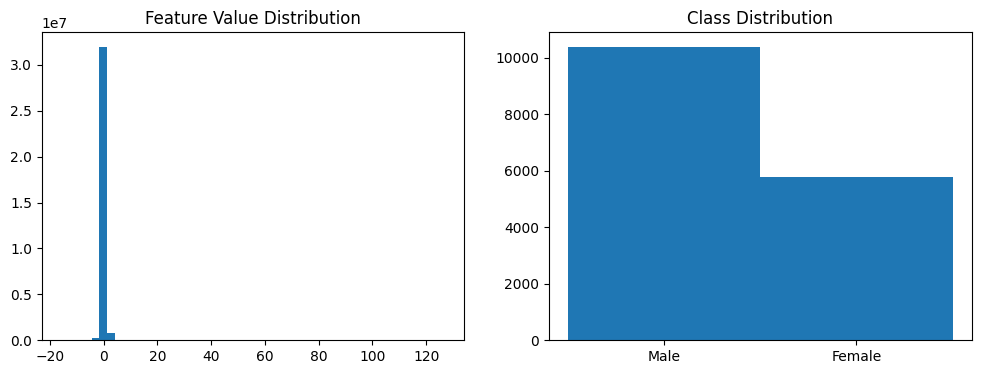

Graph info: 16148 nodes, 161480 edges

Testing simple model first...
Epoch 000: Loss=1.0710, Val Acc=0.9251
Epoch 010: Loss=0.1079, Val Acc=0.9724
Epoch 020: Loss=0.0863, Val Acc=0.9771
Epoch 030: Loss=0.0716, Val Acc=0.9774
Epoch 040: Loss=0.0668, Val Acc=0.9771
Epoch 050: Loss=0.0621, Val Acc=0.9796
Epoch 060: Loss=0.0554, Val Acc=0.9796
Epoch 070: Loss=0.0526, Val Acc=0.9793
Epoch 080: Loss=0.0513, Val Acc=0.9799
Epoch 090: Loss=0.0499, Val Acc=0.9796
Epoch 100: Loss=0.0460, Val Acc=0.9789
Epoch 110: Loss=0.0462, Val Acc=0.9783
Epoch 120: Loss=0.0432, Val Acc=0.9793
Epoch 130: Loss=0.0426, Val Acc=0.9783
Epoch 140: Loss=0.0427, Val Acc=0.9796
Epoch 150: Loss=0.0418, Val Acc=0.9805
Epoch 160: Loss=0.0410, Val Acc=0.9802
Epoch 170: Loss=0.0415, Val Acc=0.9805
Epoch 180: Loss=0.0391, Val Acc=0.9783
Epoch 190: Loss=0.0403, Val Acc=0.9780


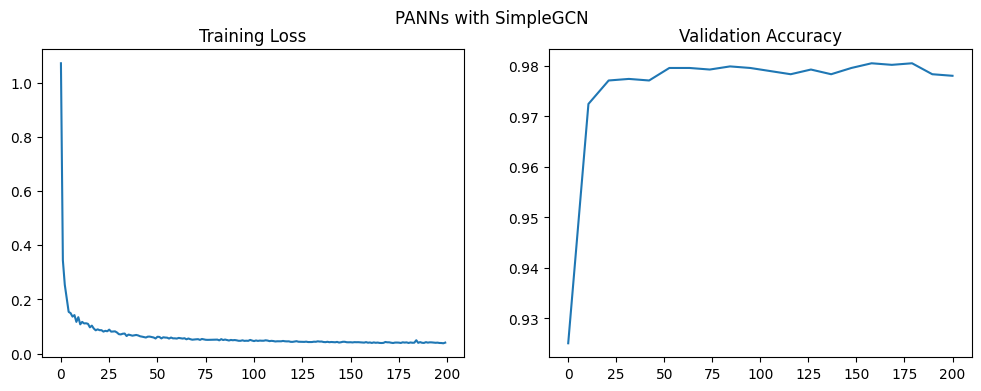

Simple model accuracy: 0.9789

Training GCN with PANNs features
Epoch 000: Loss=1.2352, Val Acc=0.9607
Epoch 010: Loss=0.1807, Val Acc=0.9759
Epoch 020: Loss=0.1039, Val Acc=0.9746
Epoch 030: Loss=0.0759, Val Acc=0.9774
Epoch 040: Loss=0.0673, Val Acc=0.9752
Epoch 050: Loss=0.0625, Val Acc=0.9780
Epoch 060: Loss=0.0526, Val Acc=0.9771
Epoch 070: Loss=0.0522, Val Acc=0.9774
Epoch 080: Loss=0.0502, Val Acc=0.9783
Epoch 090: Loss=0.0479, Val Acc=0.9780
Epoch 100: Loss=0.0461, Val Acc=0.9771
Epoch 110: Loss=0.0431, Val Acc=0.9780
Epoch 120: Loss=0.0433, Val Acc=0.9780
Epoch 130: Loss=0.0448, Val Acc=0.9780
Epoch 140: Loss=0.0430, Val Acc=0.9768
Epoch 150: Loss=0.0433, Val Acc=0.9771
Epoch 160: Loss=0.0400, Val Acc=0.9783
Epoch 170: Loss=0.0402, Val Acc=0.9783
Epoch 180: Loss=0.0397, Val Acc=0.9793
Epoch 190: Loss=0.0367, Val Acc=0.9768


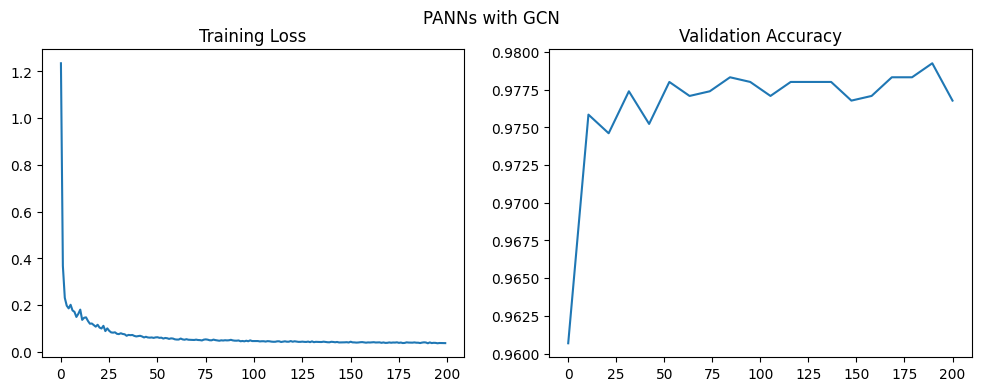

GCN with PANNs: Test Acc = 0.9777

Training GAT with PANNs features
Epoch 000: Loss=2.9683, Val Acc=0.9307
Epoch 010: Loss=0.5052, Val Acc=0.9669
Epoch 020: Loss=0.3601, Val Acc=0.9678
Epoch 030: Loss=0.2638, Val Acc=0.9675
Epoch 040: Loss=0.2116, Val Acc=0.9706
Epoch 050: Loss=0.1579, Val Acc=0.9728
Epoch 060: Loss=0.1309, Val Acc=0.9746
Epoch 070: Loss=0.1335, Val Acc=0.9759
Epoch 080: Loss=0.1193, Val Acc=0.9771
Epoch 090: Loss=0.1178, Val Acc=0.9780
Epoch 100: Loss=0.1112, Val Acc=0.9780
Epoch 110: Loss=0.1092, Val Acc=0.9783
Epoch 120: Loss=0.0998, Val Acc=0.9793
Epoch 130: Loss=0.1061, Val Acc=0.9799
Epoch 140: Loss=0.0964, Val Acc=0.9793
Epoch 150: Loss=0.0988, Val Acc=0.9799
Epoch 160: Loss=0.0982, Val Acc=0.9808
Epoch 170: Loss=0.0989, Val Acc=0.9811
Epoch 180: Loss=0.0956, Val Acc=0.9808
Epoch 190: Loss=0.0935, Val Acc=0.9808


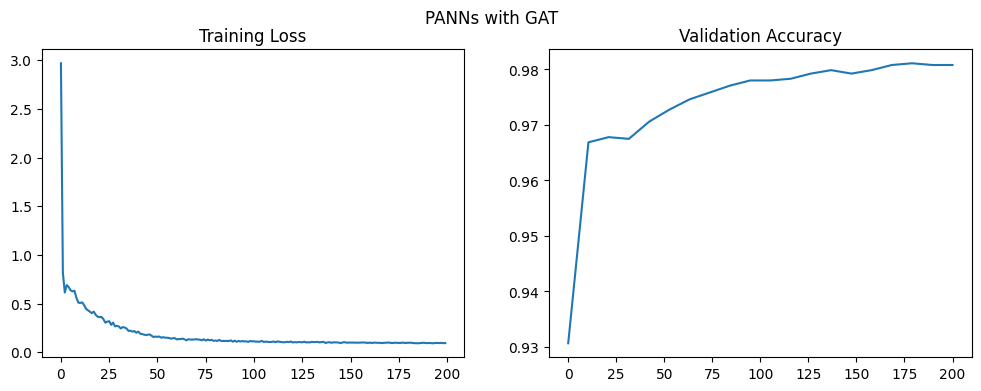

GAT with PANNs: Test Acc = 0.9808

Training GraphSAGE with PANNs features
Epoch 000: Loss=0.7169, Val Acc=0.9489
Epoch 010: Loss=0.0691, Val Acc=0.9836
Epoch 020: Loss=0.0310, Val Acc=0.9864
Epoch 030: Loss=0.0254, Val Acc=0.9882
Epoch 040: Loss=0.0162, Val Acc=0.9910
Epoch 050: Loss=0.0144, Val Acc=0.9904
Epoch 060: Loss=0.0099, Val Acc=0.9920
Epoch 070: Loss=0.0070, Val Acc=0.9916
Epoch 080: Loss=0.0058, Val Acc=0.9929
Epoch 090: Loss=0.0047, Val Acc=0.9932
Epoch 100: Loss=0.0058, Val Acc=0.9932
Epoch 110: Loss=0.0054, Val Acc=0.9916
Epoch 120: Loss=0.0060, Val Acc=0.9920
Epoch 130: Loss=0.0032, Val Acc=0.9926
Epoch 140: Loss=0.0054, Val Acc=0.9941
Epoch 150: Loss=0.0058, Val Acc=0.9935
Epoch 160: Loss=0.0072, Val Acc=0.9929
Epoch 170: Loss=0.0043, Val Acc=0.9923
Epoch 180: Loss=0.0031, Val Acc=0.9935
Epoch 190: Loss=0.0044, Val Acc=0.9932


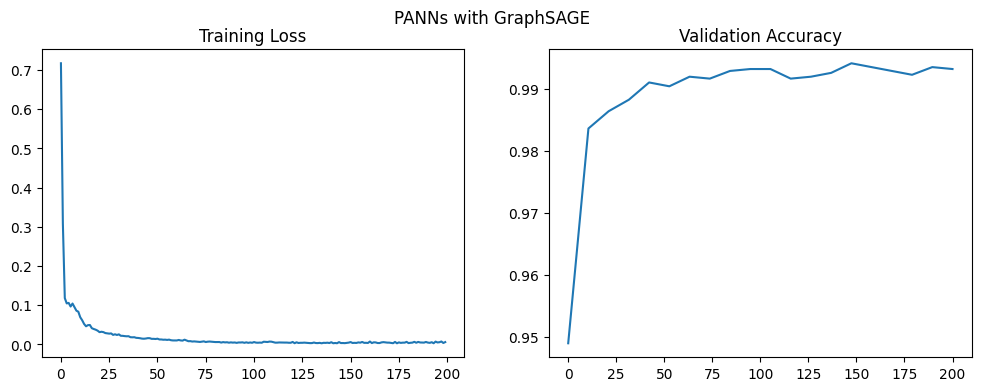

GraphSAGE with PANNs: Test Acc = 0.9932

=== Final Results ===
VGGish_GCN: 0.9988
VGGish_GAT: 0.9985
VGGish_GraphSAGE: 0.9985
YAMNet_GCN: 0.9780
YAMNet_GAT: 0.9796
YAMNet_GraphSAGE: 0.9898
PANNs_GCN: 0.9777
PANNs_GAT: 0.9808
PANNs_GraphSAGE: 0.9932


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, SAGEConv, GATConv
from sklearn.model_selection import train_test_split
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Fix random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# 1. Load and prepare data
def load_and_prepare_data():
    features = {
        'VGGish': np.load('./audio_features/vggish_features.npy'),
        'YAMNet': np.load('./audio_features/yamnet_features.npy'),
        'PANNs': np.load('./audio_features/panns_features.npy')
    }

    metadata = pd.read_csv('./audio_features/file_metadata.csv')

    # Using the existing gender columns
    valid_mask = metadata['gender'].isin(['male', 'female'])
    labels = metadata.loc[valid_mask, 'gender'].map({'male': 0, 'female': 1}).values

    for model in features:
        features[model] = features[model][valid_mask]

    print(f"Valid samples: {len(labels)} (Male: {sum(labels==0)}, Female: {sum(labels==1)})")
    return features, labels



# 2. Graph construction
def build_graph(features, labels, k=10, plot_dist=False):
    """Build graph with debugging features"""
    # Standardize features
    scaler = StandardScaler()
    features = scaler.fit_transform(features)

    # Build k-NN graph
    adj_matrix = kneighbors_graph(features, n_neighbors=k, mode='connectivity', include_self=False)

    # Convert to edge index
    row, col = adj_matrix.nonzero()
    edge_index = torch.tensor(np.vstack([row, col]), dtype=torch.long)

    # Create graph data object
    x = torch.tensor(features, dtype=torch.float)
    y = torch.tensor(labels, dtype=torch.long)

    # Plot feature distribution
    if plot_dist:
        plt.figure(figsize=(12, 4))
        plt.subplot(121)
        plt.hist(features.ravel(), bins=50)
        plt.title("Feature Value Distribution")
        plt.subplot(122)
        plt.hist(labels, bins=[-0.5, 0.5, 1.5])
        plt.xticks([0, 1], ['Male', 'Female'])
        plt.title("Class Distribution")
        plt.show()

    print(f"Graph info: {x.shape[0]} nodes, {edge_index.shape[1]} edges")
    return Data(x=x, edge_index=edge_index, y=y)

# 3. GNN Models: GCN
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.dropout = 0.5

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)


# 4. GNN Models: GAT
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=0.5)
        self.conv2 = GATConv(hidden_channels*heads, out_channels, heads=1, concat=False, dropout=0.5)
        self.dropout = 0.5

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# 5. GNN Models: GraphSAGE
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, out_channels)
        self.dropout = 0.5

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)


# 6. Training with masking and debugging
def train_and_evaluate(model, data, model_name, feature_name):
    # Create train/test masks
    idx = np.arange(data.num_nodes)
    # Moveing data.y to CPU and convert to numpy
    train_idx, test_idx = train_test_split(idx, test_size=0.2, stratify=data.y.cpu().numpy())

    data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    data.train_mask[train_idx] = True
    data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    data.test_mask[test_idx] = True

    # Model setup
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
    criterion = torch.nn.NLLLoss()

    # Training loop
    train_losses, val_accs = [], []
    for epoch in range(200):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Validation
        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                _, pred = model(data).max(dim=1)
                correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
                acc = correct / data.test_mask.sum().item()
                val_accs.append(acc)
                print(f'Epoch {epoch:03d}: Loss={loss:.4f}, Val Acc={acc:.4f}')

    # Final evaluation
    model.eval()
    _, pred = model(data).max(dim=1)
    test_acc = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.plot(train_losses)
    plt.title("Training Loss")
    plt.subplot(122)
    plt.plot(np.linspace(0, 200, len(val_accs)), val_accs)
    plt.title("Validation Accuracy")
    plt.suptitle(f"{feature_name} with {model_name}")
    plt.show()

    return test_acc

# 7. Main execution flow
def main():
    # Load data
    features, labels = load_and_prepare_data()

    results = {}
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    for feature_name, feature_array in features.items():
        # Build graph with visualization
        graph_data = build_graph(feature_array, labels, k=10, plot_dist=True)
        graph_data = graph_data.to(device)

        # Test simple model first
        print("\nTesting simple model first...")
        test_model = GCN(graph_data.num_node_features, 32, 2).to(device)
        test_acc = train_and_evaluate(test_model, graph_data, "SimpleGCN", feature_name)
        print(f"Simple model accuracy: {test_acc:.4f}")

        # Test full models
        models = {
            'GCN': GCN(graph_data.num_node_features, 64, 2).to(device),
            'GAT': GAT(graph_data.num_node_features, 32, 2, heads=4).to(device),
            'GraphSAGE': GraphSAGE(graph_data.num_node_features, 64, 2).to(device)
        }

        for model_name, model in models.items():
            print(f"\nTraining {model_name} with {feature_name} features")
            acc = train_and_evaluate(model, graph_data, model_name, feature_name)
            results[f"{feature_name}_{model_name}"] = acc
            print(f"{model_name} with {feature_name}: Test Acc = {acc:.4f}")

    # Print final results
    print("\n=== Final Results ===")
    for model_name, acc in results.items():
        print(f"{model_name}: {acc:.4f}")

    return results


if __name__ == "__main__":
    main()

Valid samples: 16148 (Male: 10380, Female: 5768)
Using device: cuda
Graph info: 16148 nodes, 161480 edges

Training and Evaluating GCN with VGGish features


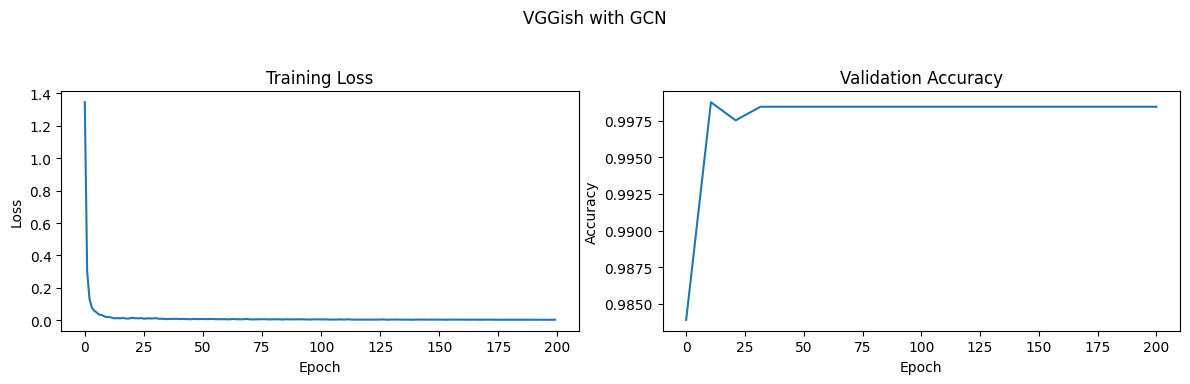

--- GCN with VGGish Metrics ---
Accuracy: 0.9985
Precision: 0.9985
Recall: 0.9985
F1-Score: 0.9985
Training Time: 1.86 seconds
-------------------------------

Training and Evaluating GAT with VGGish features


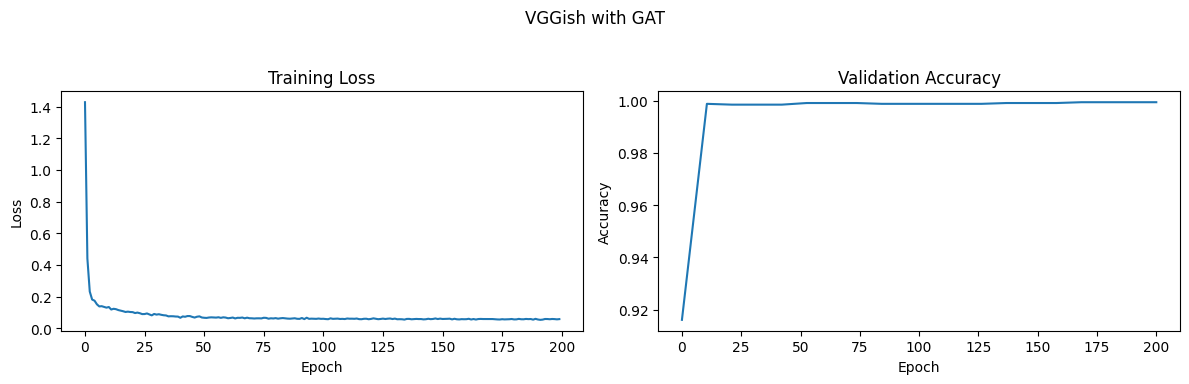

--- GAT with VGGish Metrics ---
Accuracy: 0.9994
Precision: 0.9994
Recall: 0.9994
F1-Score: 0.9994
Training Time: 2.64 seconds
-------------------------------

Training and Evaluating GraphSAGE with VGGish features


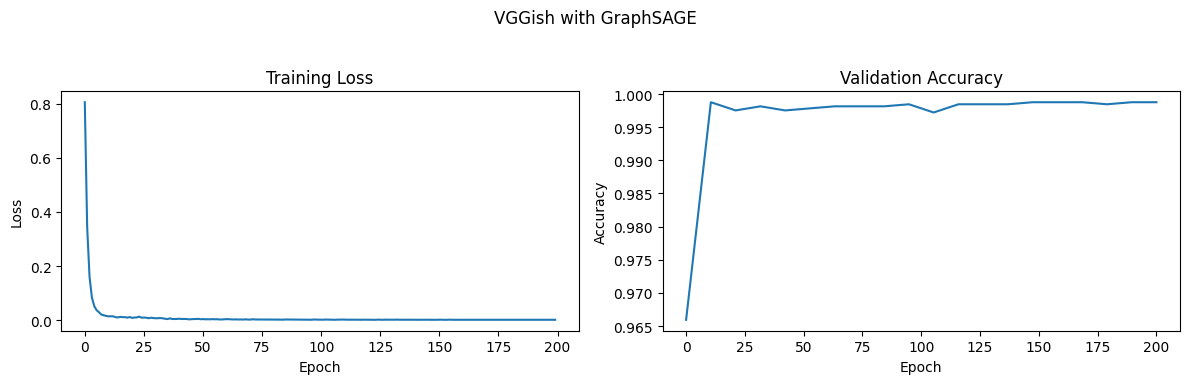

--- GraphSAGE with VGGish Metrics ---
Accuracy: 0.9988
Precision: 0.9988
Recall: 0.9988
F1-Score: 0.9988
Training Time: 1.68 seconds
-------------------------------------
Graph info: 16148 nodes, 161480 edges

Training and Evaluating GCN with YAMNet features


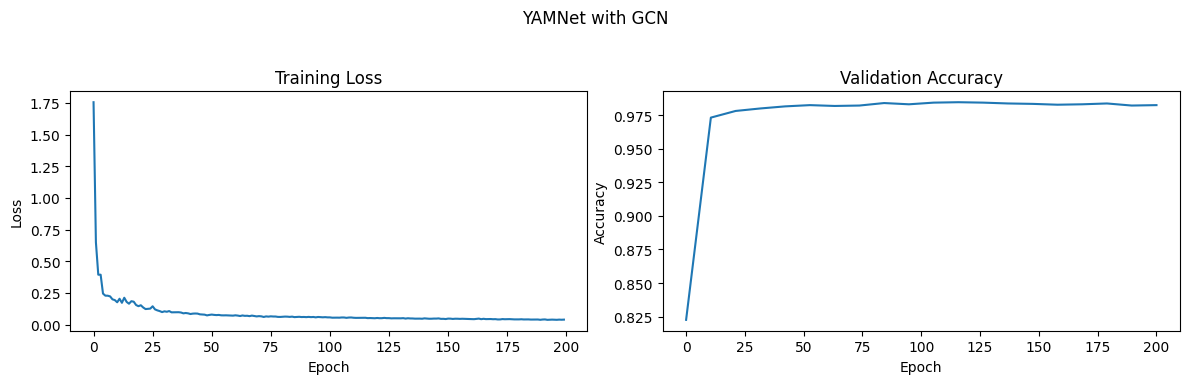

--- GCN with YAMNet Metrics ---
Accuracy: 0.9830
Precision: 0.9830
Recall: 0.9830
F1-Score: 0.9829
Training Time: 2.09 seconds
-------------------------------

Training and Evaluating GAT with YAMNet features


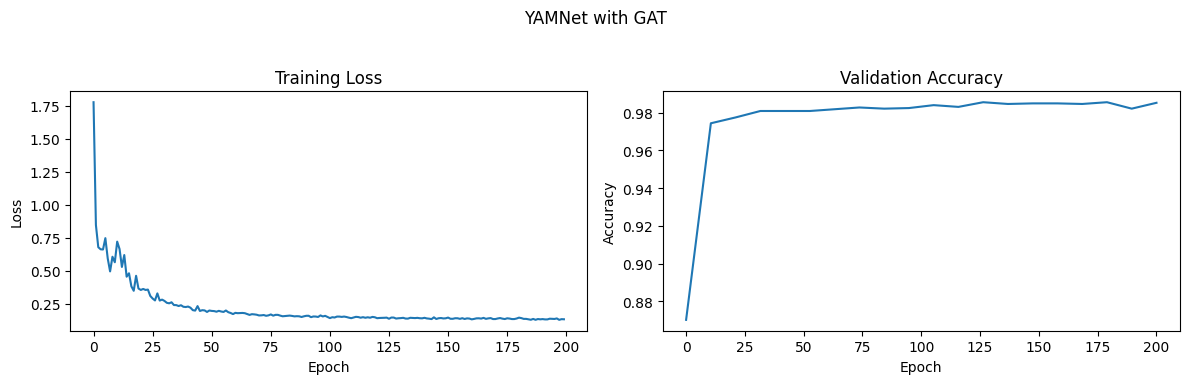

--- GAT with YAMNet Metrics ---
Accuracy: 0.9833
Precision: 0.9833
Recall: 0.9833
F1-Score: 0.9833
Training Time: 3.00 seconds
-------------------------------

Training and Evaluating GraphSAGE with YAMNet features


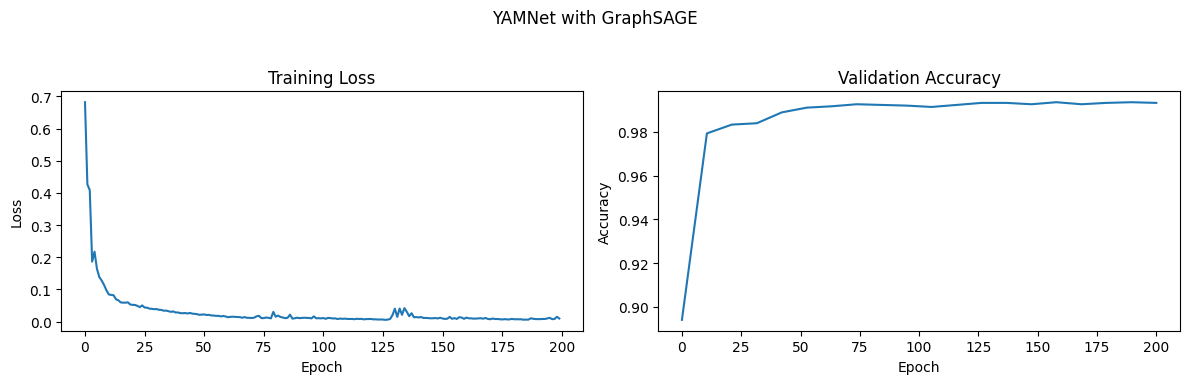

--- GraphSAGE with YAMNet Metrics ---
Accuracy: 0.9929
Precision: 0.9929
Recall: 0.9929
F1-Score: 0.9929
Training Time: 5.11 seconds
-------------------------------------
Graph info: 16148 nodes, 161480 edges

Training and Evaluating GCN with PANNs features


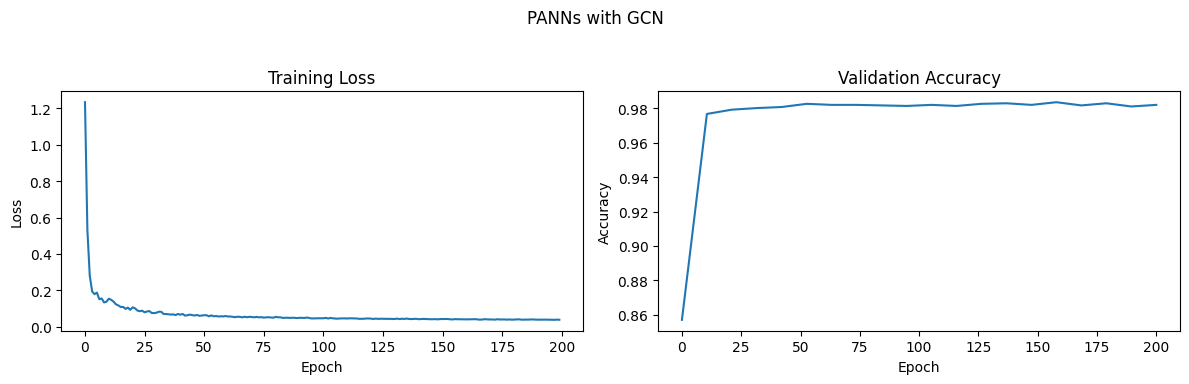

--- GCN with PANNs Metrics ---
Accuracy: 0.9817
Precision: 0.9817
Recall: 0.9817
F1-Score: 0.9817
Training Time: 2.34 seconds
------------------------------

Training and Evaluating GAT with PANNs features


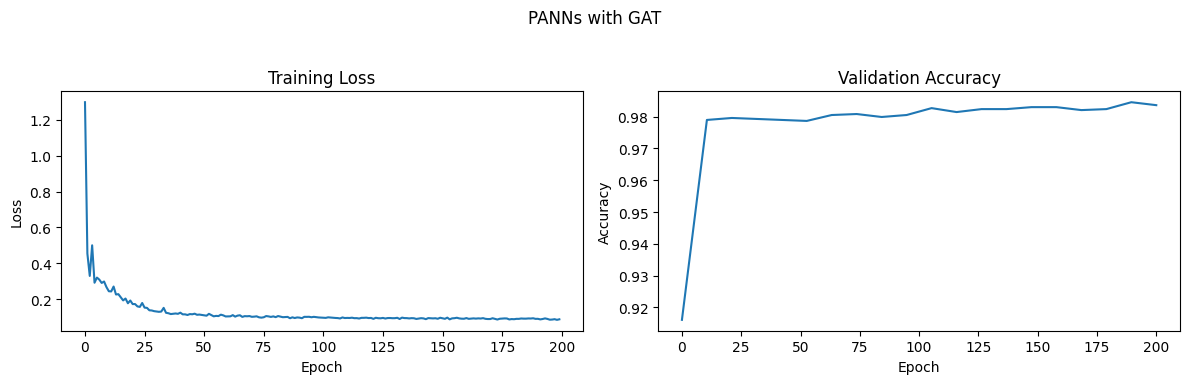

--- GAT with PANNs Metrics ---
Accuracy: 0.9833
Precision: 0.9833
Recall: 0.9833
F1-Score: 0.9833
Training Time: 3.46 seconds
------------------------------

Training and Evaluating GraphSAGE with PANNs features


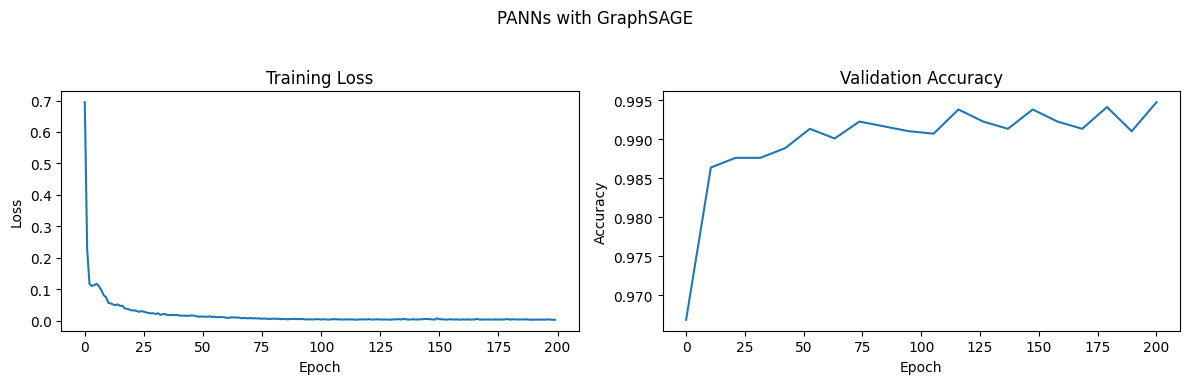

--- GraphSAGE with PANNs Metrics ---
Accuracy: 0.9923
Precision: 0.9923
Recall: 0.9923
F1-Score: 0.9923
Training Time: 9.17 seconds
------------------------------------

FINAL PERFORMANCE COMPARISON

Performance Metrics per Model and Feature:
|                  | accuracy   | precision   | recall   | f1_score   | training_time   |
|:-----------------|:-----------|:------------|:---------|:-----------|:----------------|
| VGGish_GCN       | 0.9985     | 0.9985      | 0.9985   | 0.9985     | 1.8571          |
| VGGish_GAT       | 0.9994     | 0.9994      | 0.9994   | 0.9994     | 2.6403          |
| VGGish_GraphSAGE | 0.9988     | 0.9988      | 0.9988   | 0.9988     | 1.6847          |
| YAMNet_GCN       | 0.9830     | 0.9830      | 0.9830   | 0.9829     | 2.0871          |
| YAMNet_GAT       | 0.9833     | 0.9833      | 0.9833   | 0.9833     | 2.9976          |
| YAMNet_GraphSAGE | 0.9929     | 0.9929      | 0.9929   | 0.9929     | 5.1052          |
| PANNs_GCN        | 0.9817     | 0.9

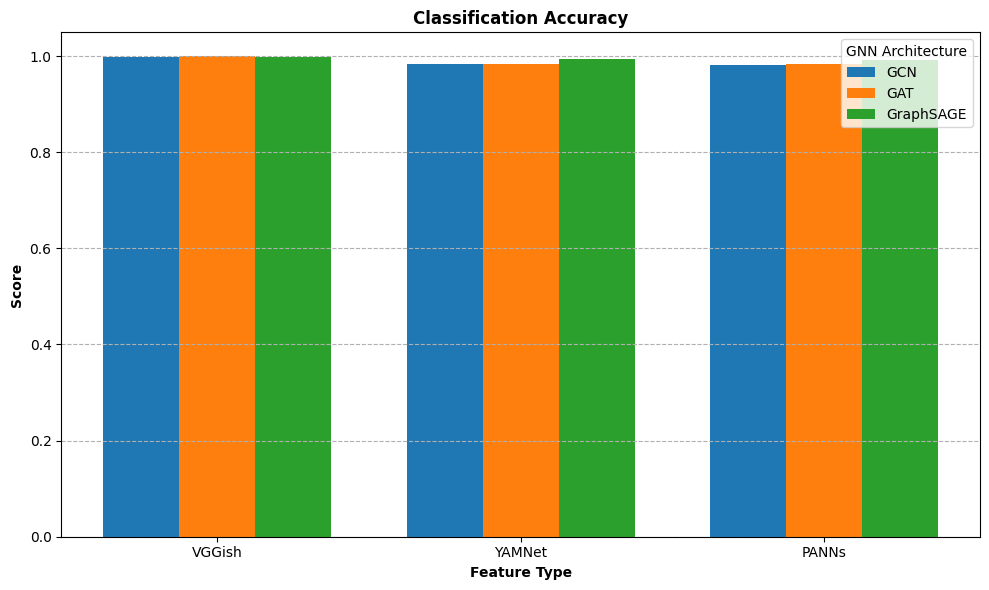

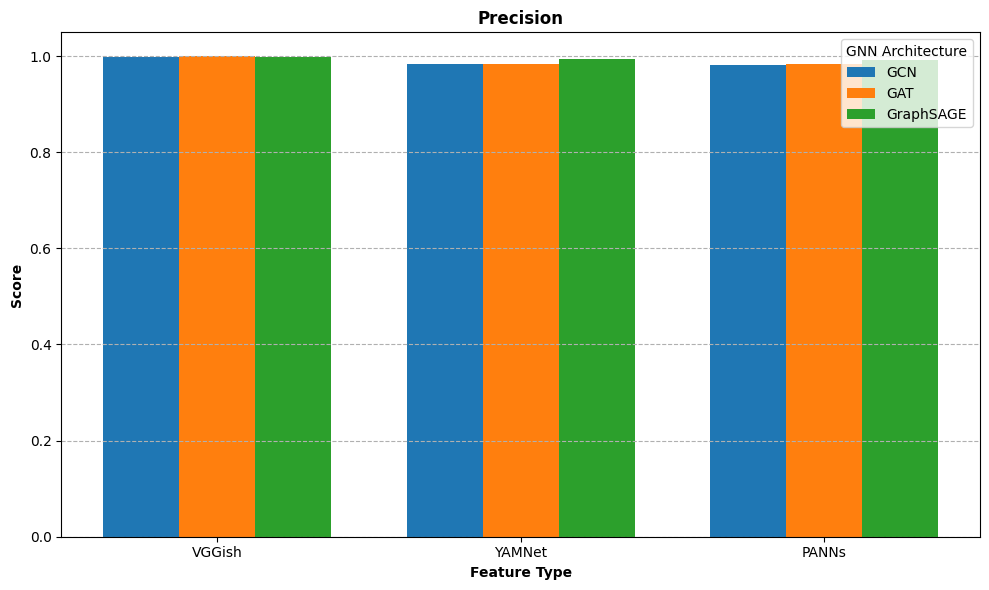

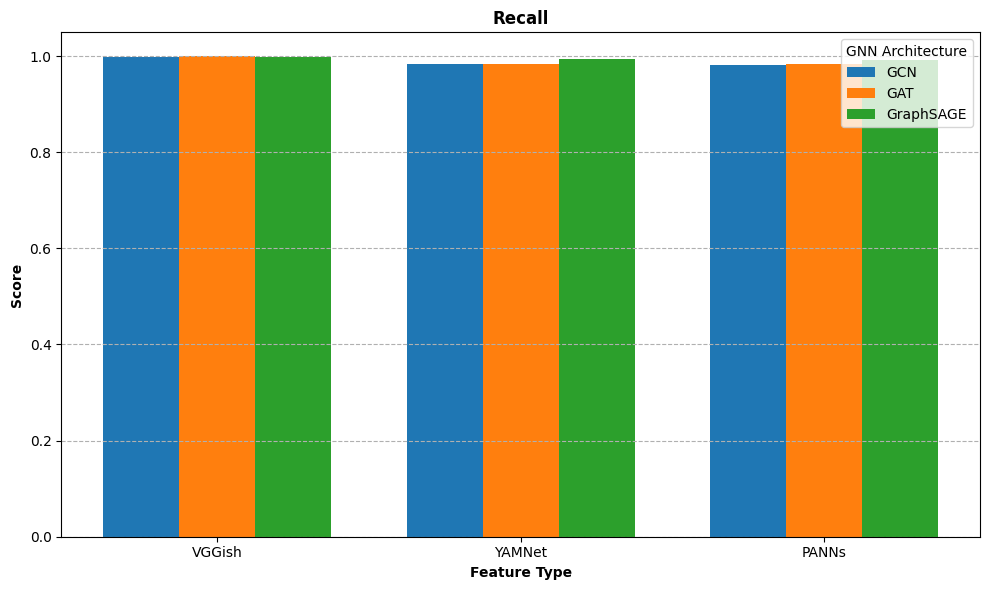

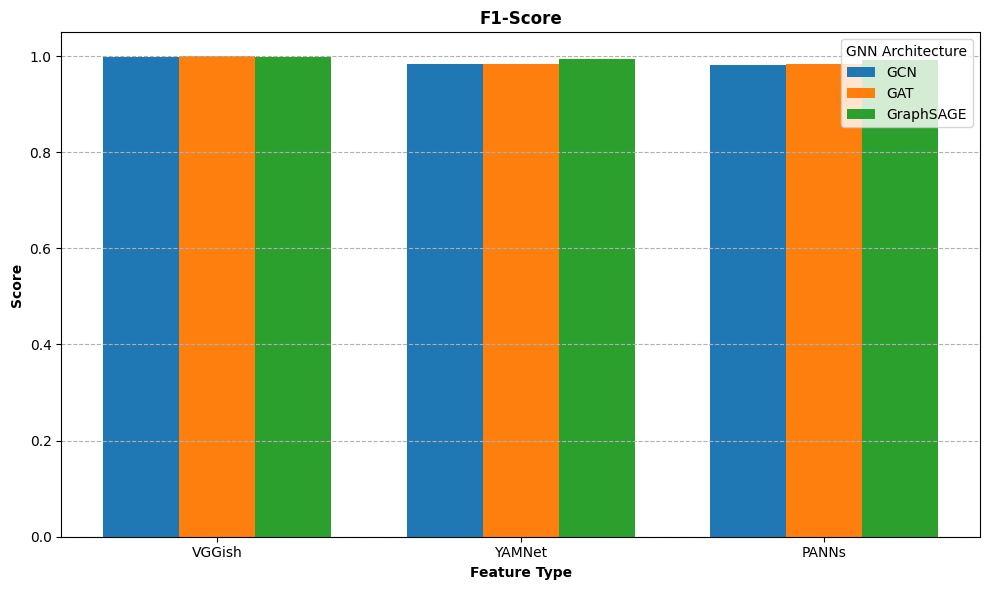

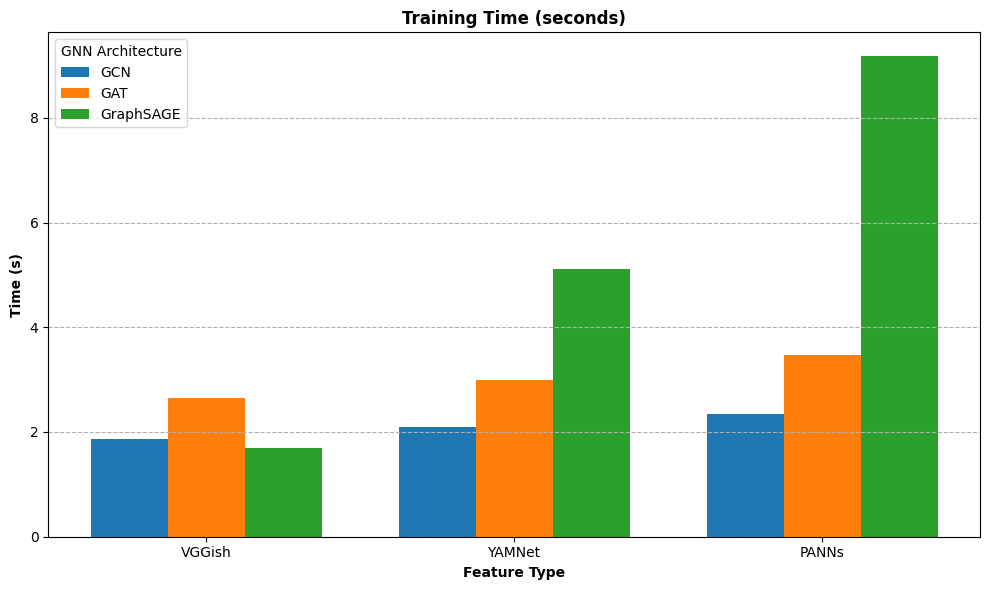

In [ ]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time

# Training and evaluation with comprehensive metrics and timing
def train_and_evaluate(model, data, model_name, feature_name):
    # Create train/test masks
    idx = np.arange(data.num_nodes)
    train_idx, test_idx = train_test_split(idx, test_size=0.2, stratify=data.y.cpu().numpy())

    data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    data.train_mask[train_idx] = True
    data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    data.test_mask[test_idx] = True

    # Model setup
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
    criterion = torch.nn.NLLLoss()

    # Training loop
    train_losses, val_accs = [], []
    start_time = time.time() # Start timing training
    for epoch in range(200):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Validation
        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                _, pred = model(data).max(dim=1)
                correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
                acc = correct / data.test_mask.sum().item()
                val_accs.append(acc)

    end_time = time.time() # End timing training
    training_time = end_time - start_time

    # Final evaluation
    model.eval()
    with torch.no_grad():
        logits = model(data)
        _, pred = logits.max(dim=1)

        # Calculate metrics
        y_true = data.y[data.test_mask].cpu().numpy()
        y_pred = pred[data.test_mask].cpu().numpy()

        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)


    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.plot(train_losses)
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.subplot(122)
    plt.plot(np.linspace(0, 200, len(val_accs)), val_accs)
    plt.title("Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.suptitle(f"{feature_name} with {model_name}")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'training_time': training_time
    }

    print(f"--- {model_name} with {feature_name} Metrics ---")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1-Score: {metrics['f1_score']:.4f}")
    print(f"Training Time: {metrics['training_time']:.2f} seconds")
    print("-" * (len(f"--- {model_name} with {feature_name} Metrics ---")))


    return metrics


# Main execution flow with metric collection and visualization
def main():
    # Load data
    features, labels = load_and_prepare_data()

    # Store results in a dictionary indexed by feature and model
    all_results = {}

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    for feature_name, feature_array in features.items():
        # Build graph with visualization
        graph_data = build_graph(feature_array, labels, k=10, plot_dist=False) # Set plot_dist to False for cleaner output during full runs
        graph_data = graph_data.to(device)



        # Test full models
        models_to_test = {
            'GCN': GCN(graph_data.num_node_features, 64, 2).to(device),
            'GAT': GAT(graph_data.num_node_features, 32, 2, heads=4).to(device),
            'GraphSAGE': GraphSAGE(graph_data.num_node_features, 64, 2).to(device)
        }

        for model_name, model in models_to_test.items():
            print(f"\nTraining and Evaluating {model_name} with {feature_name} features")
            metrics = train_and_evaluate(model, graph_data, model_name, feature_name)
            all_results[f"{feature_name}_{model_name}"] = metrics


    # Print and Visualize Final Results
    print("\n" + "="*50)
    print("FINAL PERFORMANCE COMPARISON")
    print("="*50)

    # Convert results to a pandas DataFrame
    results_df = pd.DataFrame(all_results).T # Transpose to have models/features as rows

    print("\nPerformance Metrics per Model and Feature:")
    print(results_df[['accuracy', 'precision', 'recall', 'f1_score', 'training_time']].to_markdown(numalign="left", stralign="left", floatfmt=".4f"))

    # Visualization
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score', 'training_time']
    titles = ['Classification Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time (seconds)']
    ylabels = ['Score', 'Score', 'Score', 'Score', 'Time (s)']


    for i, metric in enumerate(metrics_to_plot):
        plt.figure(figsize=(10, 6))
        # Extract data for plotting
        metric_data = results_df[metric]

        # Separate by feature type for grouping
        feature_types = ['VGGish', 'YAMNet', 'PANNs']
        model_types = ['GCN', 'GAT', 'GraphSAGE']

        bar_width = 0.2
        r = np.arange(len(feature_types)) * (len(model_types) * bar_width + bar_width)
        for j, model_name in enumerate(model_types):
            model_values = [metric_data.get(f"{feature_type}_{model_name}", 0) for feature_type in feature_types]
            plt.bar(r + j * bar_width, model_values, width=bar_width, label=model_name)


        plt.xlabel("Feature Type", fontweight='bold')
        plt.ylabel(ylabels[i], fontweight='bold')
        plt.title(titles[i], fontweight='bold')
        plt.xticks(r + bar_width * (len(model_types) - 1) / 2, feature_types)
        plt.legend(title="GNN Architecture")
        plt.grid(axis='y', linestyle='--')
        plt.tight_layout()
        plt.show()

    return all_results


if __name__ == "__main__":
    final_comparison_results = main()
